In [4]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform

from hourglass import hg

In [2]:
def heatmaps_to_locs(heatmaps):
    heatmaps = heatmaps.numpy()
    conf = np.max(heatmaps, axis=(-2,-1))
    locs = np.argmax(heatmaps.reshape((*heatmaps.shape[:2], -1)), axis=-1)
    locs = np.stack(np.unravel_index(locs, (64, 64))[::-1], axis=-1) # reverse x,y
    return np.concatenate([locs, conf[..., None]], axis=-1).astype('float32')
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=20, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = hg(num_stacks=1, num_blocks=1, num_classes=4).to(device,dtype=torch.float)
checkpoint = torch.load('checkpoints/model_2c.pt')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [41]:
def image_inference(model,image):
    model.eval()
    im = image
    im = transform.resize(im, (256,256))
    im = im.transpose((2, 0, 1))
    im = torch.from_numpy(im)
    output = model(im.view(-1,3,256,256).to(device,dtype=torch.float))
    
    maps = output[0][0].cpu().detach().numpy()
    hd = maps[0,:,:] + maps[1,:,:] + maps[2,:,:]+maps[3,:,:]
    plt.imshow(hd,cmap='hot')
    plt.show()
    im = im.numpy()
    im = im.transpose(1,2,0)
    grasp_points = heatmaps_to_locs(output[0].cpu().detach())
    grasp_points = grasp_points[0,:,:2]*4
    show_landmarks(im,grasp_points[0:4])
    

# Inference On Images

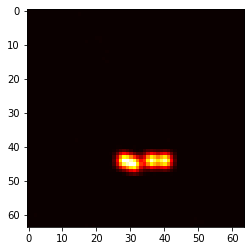

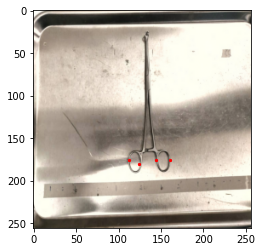

In [47]:
img = io.imread("images/sample1.jpg")
image_inference(model,img)

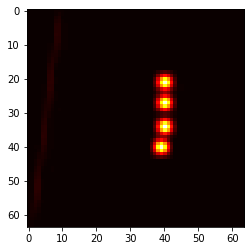

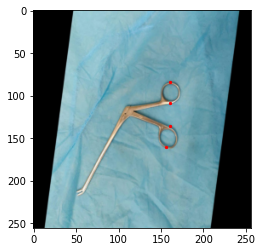

In [48]:
img = io.imread("images/sample2.jpg")
image_inference(model,img)